In [41]:
# first step was to implement this to make sure notebook runs correctly and can reproduce plots
# https://nbviewer.org/urls/qutip.org/qutip-tutorials/tutorials-v4/lectures/Lecture-10-cQED-dispersive-regime.ipynb
%matplotlib widget

import qutip
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from qutip import (Options, about, basis, coherent, correlation, destroy,
                   expect, mesolve, ptrace, qeye, sigmax, sigmaz,
                   spectrum_correlation_fft, tensor, wigner)
from tqdm import tqdm
import numpy as np
from qutip.ui.progressbar import EnhancedTextProgressBar

In [42]:
class Model: 
    """Class to initiate and hold physical properties of system"""
    
    def __init__(self, **kwargs):
        """Initialize model parameters
        kwargs:
            - N: number of cavity modes, default 10
            - cavityFreq: cavity frequency, default 7.5*np.pi
            - qubitFreq: qubit frequency, default 5.0*np.pi
            - cavityDecay: cavity decay rate, default .1
            - qubitDecay: qubit decay rate, default .0001
            - chi: qubit-cavity coupling strength, default .002*2*np.pi
            - noise: noise strength, default 0 (not implemented)
            - psi0: initial state, default tensor(basis(N, 0), (basis(2, 0)).unit())
        """
        
        # TODO add some uniform variation in parameters (or ability to override)

        ### Define Physical Parameters ###
        self.N = 10
        # TODO make sure consist with GHz vs rad/s
        # XXX possibly off by a factor of 2pi or hbar
        self.cavityFreq = 7.5*np.pi
        self.qubitFreq = 5.0*np.pi

        # NOTE cavity much longer lived than qubit
        self.cavityDecay = .001 # 1-5Mhz
        self.qubitDecay = .0001 #1-5 kHz (or less)

        self.chi = 0.002*2*np.pi #g^2/delta (some conventions are negative)

        # TODO add noise
        self.noise = 0

        # define initial state
        # XXX using 2-level system for qubit
        # later will become transmon
        self.psi0 = tensor(basis(self.N, 0), (basis(2, 0)).unit())

        # ### Construct Operators ###
        # cavity operators
        self.c = tensor(destroy(self.N), qeye(2))
        self.c_H0 = self.c.dag() + self.c
        c_collapse = np.sqrt(self.cavityDecay) * self.c
        # TODO add cavity excitation function of avg. photon number (?)
        c_n = self.c.dag() * self.c

        # qubit operators
        self.q = tensor(qeye(self.N), destroy(2))
        self.q_H0 = self.q.dag() + self.q
        q_collapse = np.sqrt(self.qubitDecay) * self.q
        q_n = self.q.dag() * self.q

        self.c_ops = [c_collapse, q_collapse]
        self.e_ops = [c_n, q_n]

In [43]:
class Hamiltonian():
    """Class to hold Hamiltonian of system"""
    
    def __init__(self, model: Model, tlist=None, progress_bar=None):
        """Initializes Hamiltonian object
        args:
            - model: Model object containing physical parameters
            - tlist: list of times to evaluate Hamiltonian at, if None then defaults to 0 to 150 with 50 points
            - progress_bar: whether to show progress bar, default False
        """
        self.model = model
        self.tlist = tlist if tlist else np.linspace(0, 150,50)
        self.progress_bar = False if progress_bar is None else progress_bar
        
        # Jaynes-Cummings Hamiltonian (?)
        Id = tensor(qeye(self.model.N), qeye(2))
        sz = tensor(qeye(self.model.N), sigmaz())
        self.H0 = model.cavityFreq * (self.model.c.dag() * self.model.c + Id / 2.0) + (self.model.qubitFreq / 2.0) * sz - (self.model.chi/2) *(self.model.c.dag() * self.model.c) * sz

    # TODO figure out a more pythonic way to programmatically create 
    # time-dependent terms and c_ops functions (unnecessary?)

    def _qubit_drive_hamiltonian(self, t, kwargs):
        """Time-dependent drive hamiltonian"""
        el = 'qubit'
        return kwargs[f'{el}_amplitude'] * np.cos(kwargs[f'{el}_drive_freq'] * t)
    
    def _cavity_drive_hamiltonian(self, t, kwargs):
        """Time-dependent drive hamiltonian"""
        el = 'cavity'
        return kwargs[f'{el}_amplitude'] * np.cos(kwargs[f'{el}_drive_freq'] * t)

    def wrap_mesolve(self, **kwargs):
        """Runs mesolve with given parameters and returns result
        args:
            args: dictionary of arguments to pass to solver
            - cavity_drive_freq: drive frequency of cavity, if None then drives at the cavity frequency
            - qubit_drive_freq: drive frequency of qubit, if None then drives at the qubit frequency
            (if don't specify, will presume drive at resonance)
            - qubit_amplitude: amplitude of drive on qubit, if None then drive is off
            - cavity_amplitude: amplitude of drive on cavity, if None then drive is off
        """
        H = [self.H0, [self.model.c_H0, self._cavity_drive_hamiltonian], [self.model.q_H0, self._qubit_drive_hamiltonian]]
        args = {}
        args['cavity_drive_freq'] = kwargs.get('cavity_drive_freq', self.model.cavityFreq)
        args['qubit_drive_freq'] = kwargs.get('qubit_drive_freq', self.model.qubitFreq)
        args['qubit_amplitude'] = kwargs.get('qubit_amplitude', 0)
        args['cavity_amplitude'] = kwargs.get('cavity_amplitude', 0)

        # check against this ampltiude heuristic, make sure not exceeding max photon number
        assert args['cavity_amplitude']/np.sqrt(self.model.cavityDecay) <= 1 , "Warning: cavity drive amplitude too large!" # <= self.model.N/4

        # XXX don't know best value for nsteps
        progress_bar = EnhancedTextProgressBar() if self.progress_bar else None
        return mesolve(H, self.model.psi0, self.tlist, self.model.c_ops, self.model.e_ops, args=args, options=Options(nsteps=10000), progress_bar=progress_bar)

    def _plot_example(self):
        results = self.wrap_mesolve(qubit_amplitude=0.1, cavity_amplitude=0.01)
        fig, axes = plt.subplots(1, 1, figsize=(10, 6))
        axes.plot(self.tlist, results.expect[0], label="Cavity", marker='o')
        axes.plot(self.tlist, results.expect[1], label="Qubit", marker='x')
        axes.legend()
        axes.set_xlabel('Time')
        axes.set_ylabel('Photon number')
        axes.set_title('Rabi oscillations');
        # fig.show()

 Total run time:  12.77s*] Elapsed 12.77s / Remaining 00:00:00:00


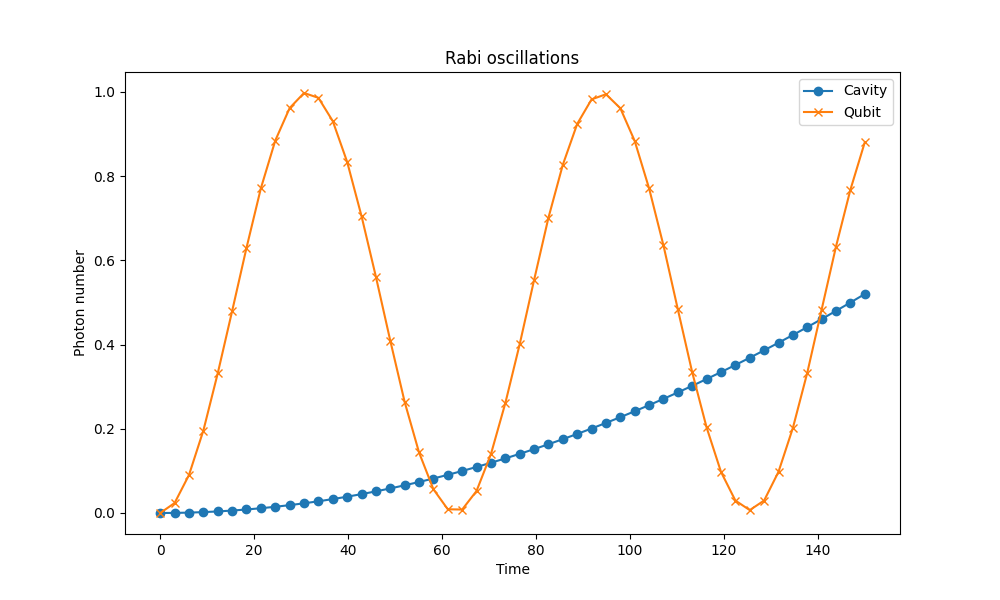

In [44]:
# verify that it works, useful for guess and checking appropriate amplitudes
h = Hamiltonian(Model(), progress_bar=True)
h._plot_example()

In [59]:
class DispersiveReadout():
    # FIXME comments
    """Experiment to measure change of the cavity's frequency due to qubit excitation
    Want to measure 
        - the change in the cavity's frequency due to qubit excitation (chi)
        - the cavity's line width (gamma)
        - amplitude of cavity readout (sqrt(n))
    Assumes we know the qubit's frequency and it has a negligible decay rate
    """
    def __init__(self):
        self.model = Model(qubitDecay=0)
        self.H = Hamiltonian(self.model)
        self.num_points = 50
        self.sweep_scale = .005
    
    def _run(self, cavity_drive_freq_list=None, qubit_amplitude=None, cavity_amplitude=None):
        """Runs experiment and returns results
        args:
            - cavity_drive_freq_list: list of cavity drive frequencies to sweep over
            (if None defaults to (1-sweep_scale)*cavityFreq to (1+sweep_scale)*cavityFreq with self.num_points)
            - qubit_amplitude: amplitude of drive on qubit, if None defaults to .1 #FIXME
            - cavity_amplitude: amplitude of drive on cavity, if None defaults to .1 #FIXME
            
        """
        # Sweep over cavity drive frequencies a) with qubit drive off and b) with qubit drive on
        cavity_drive_freq_list = cavity_drive_freq_list if cavity_drive_freq_list \
            else np.linspace((1.0-self.sweep_scale) * self.model.cavityFreq, (1.0 + self.sweep_scale) * self.model.cavityFreq, self.num_points)
        
        qubit_amplitude = qubit_amplitude if qubit_amplitude else .1 #FIXME
        cavity_amplitude = cavity_amplitude if cavity_amplitude else .01 # FIXME

        e_op_results = np.zeros((len(cavity_drive_freq_list), 2))
        for i, cavity_drive_freq in tqdm(enumerate(cavity_drive_freq_list)):

            # Run mesolve with qubit drive off
            mesolve_result = self.H.wrap_mesolve(cavity_drive_freq=cavity_drive_freq, qubit_amplitude=0, cavity_amplitude=cavity_amplitude)
            e_op_results[i, 0] = mesolve_result.expect[0][-1] # cavity photon number

            # Run mesolve with qubit drive on
            mesolve_result = self.H.wrap_mesolve(cavity_drive_freq=cavity_drive_freq, qubit_amplitude=qubit_amplitude, cavity_amplitude=cavity_amplitude)
            e_op_results[i, 1] = mesolve_result.expect[0][-1] # cavity photon number
    
        return cavity_drive_freq_list, e_op_results
    
    def plot(self, cavity_drive_freq_list=None, qubit_amplitude=None, cavity_amplitude=None):
        """Runs experiment and plots results"""
        cavity_drive_freq_list, e_op_results = self._run(cavity_drive_freq_list, qubit_amplitude, cavity_amplitude)

        fig, axes = plt.subplots(1, 1, figsize=(10, 6))
        axes.plot(cavity_drive_freq_list, e_op_results[:, 0], label='qubit off', marker='o')
        axes.plot(cavity_drive_freq_list, e_op_results[:, 1], label='qubit on', marker='x')
        axes.legend()
        axes.set_xlabel('cavity drive frequency')
        axes.set_ylabel('cavity photon number')
        # fig.show()

50it [14:17, 17.15s/it]


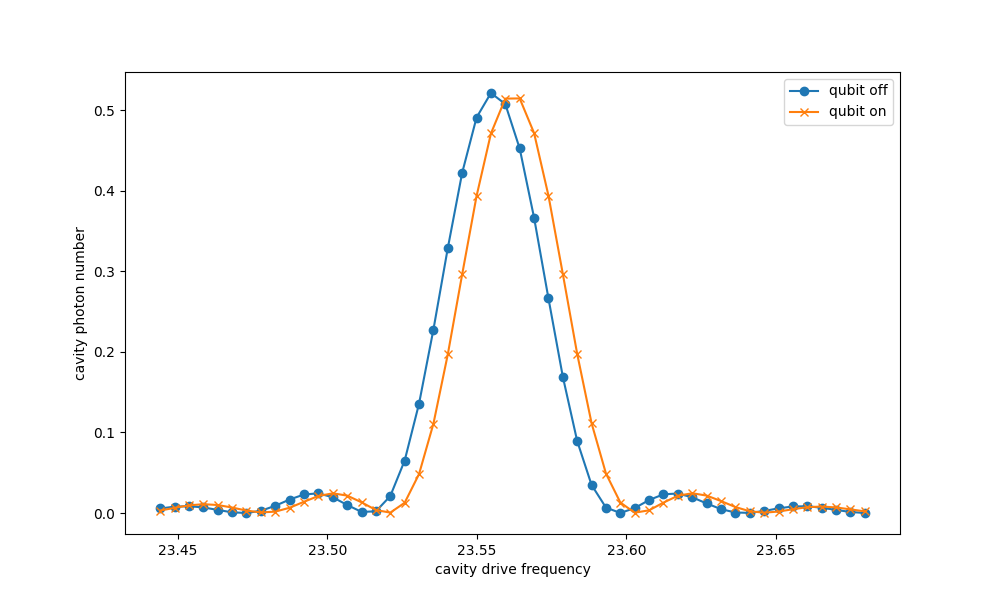

In [60]:
# verify that it works
DispersiveReadout().plot()

In [55]:
class QubitSpectroscopy():
    """
    Experiment to measure qubit frequency by sweeping over qubit drive frequency and measuring cavity photon number
    """
    def __init__(self):
        self.model = Model()
        self.H = Hamiltonian(self.model)
        self.num_points = 60
        self.sweep_scale = .038
    
    def _run(self, qubit_drive_freq_list=None, qubit_amplitude=None, cavity_amplitude=None):
        """Runs experiment and returns results
        args:
            - qubit_drive_freq_list: list of qubit drive frequencies to sweep over
            (if None defaults to (1-sweep_scale)*qubitFreq to (1+sweep_scale)*qubitFreq with self.num_points)
            - qubit_amplitude: amplitude of drive on qubit, if None defaults to .1 # FIXME
            - cavity_amplitude: amplitude of drive on cavity, if None defaults to .1 # FIXME
        """
        # Sweep over qubit drive frequencies with cavity drive always on resonance
        qubit_drive_freq_list = qubit_drive_freq_list if qubit_drive_freq_list \
            else np.linspace((1.0-self.sweep_scale) * self.model.qubitFreq, (1.0 + self.sweep_scale) * self.model.qubitFreq, self.num_points)
        
        qubit_amplitude = qubit_amplitude if qubit_amplitude else 0.1 # FIXME
        cavity_amplitude = cavity_amplitude if cavity_amplitude else 0.01 # FIXME

        e_op_results = np.zeros((len(qubit_drive_freq_list), 1))
        for i, qubit_drive_freq in tqdm(enumerate(qubit_drive_freq_list)):
            mesolve_result = self.H.wrap_mesolve(qubit_drive_freq=qubit_drive_freq, qubit_amplitude=qubit_amplitude, cavity_amplitude=cavity_amplitude)

            # TODO measure through readout signal rather than via expectation values !!!
            e_op_results[i, 0] = mesolve_result.expect[0][-1] # cavity photon number

        return qubit_drive_freq_list, e_op_results

    def plot(self, qubit_drive_freq_list=None, qubit_amplitude=None, cavity_amplitude=None):
        """Runs experiment and plots results"""
        qubit_drive_freq_list, e_op_results = self._run(qubit_drive_freq_list, qubit_amplitude, cavity_amplitude)

        fig, axes = plt.subplots(1, 1, figsize=(10, 6))
        axes.plot(qubit_drive_freq_list, e_op_results[:, 0], marker='o')
        axes.set_xlabel('qubit drive frequency')
        axes.set_ylabel('cavity photon number')
        # fig.show()

60it [08:51,  8.86s/it]


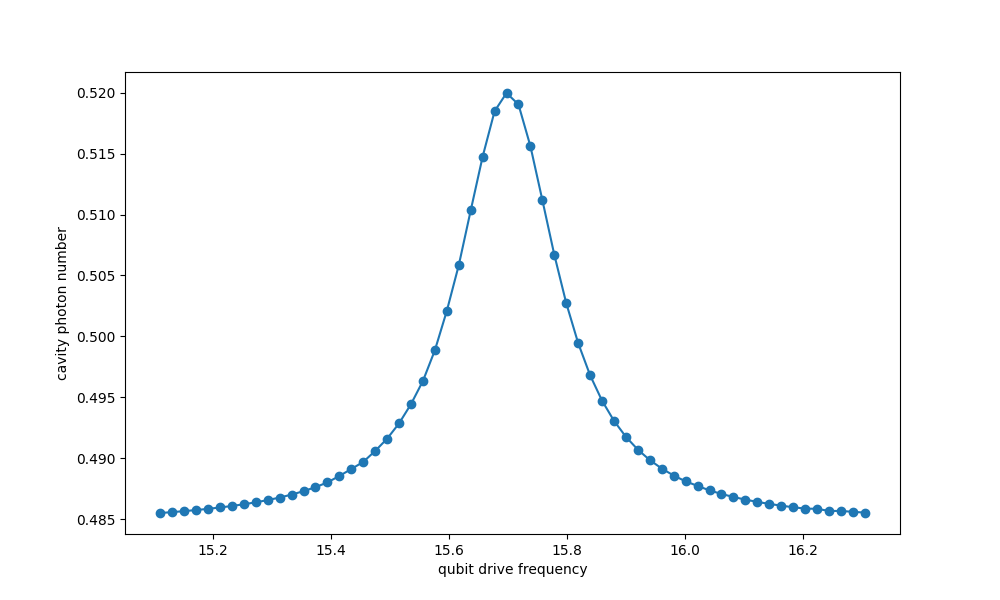

In [56]:
QubitSpectroscopy().plot()